## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
from pathlib import Path

ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH)
# Change root path
ROOT_PATH = Path(ROOT_PATH) / 'My Drive' / 'Colab Notebooks' / 'ANN&DL' / 'Homeworks' / 'Homework_2';

Mounted at /content/drive


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

import os
from datetime import datetime
import copy

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import logging
import numpy as np
import random
import albumentations as A
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)


import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


### Data cleaning

While plotting the images and their corresponding segmentations from the original training set, mars_for_students.npz, we identified some outliers (images containing an alien). We also observed that the outlier images (samples in X_train) differ from each other, whereas their corresponding segmentations are identical.  
To avoid processing the outliers in the future, we created a new dataset, cleaned_dataset.npz, which excludes these outliers.

In [ ]:
"""
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")
"""

'\ndata = np.load("mars_for_students.npz")\n\ntraining_set = data["training_set"]\nX_train = training_set[:, 0]\ny_train = training_set[:, 1]\n\nX_test = data["test_set"]\n\nprint(f"Training X shape: {X_train.shape}")\nprint(f"Training y shape: {y_train.shape}")\nprint(f"Test X shape: {X_test.shape}")\n'

In [ ]:
"""
# function that returns the list of the outliars' indices in y_train
# idx is the index corresponding to an outliar (found by visualization)

def find_outliers_idx(y_train, idx):
    # Extract the reference outlier
    outlier_reference = y_train[idx]

    # Initialize a list to store the indices of the outliers
    outliers_indices = []

    for i in range(y_train.shape[0]):
        if np.array_equal(y_train[i], outlier_reference):
            # If they are the same, add index i to the list of outlier indices
            outliers_indices.append(i)

    return outliers_indices


outlier_indices = find_outliers_idx(y_train, 62)
print(f"Number of outliers: {len(outlier_indices)}")
print("Indices of outliers:", outlier_indices)
"""

'\n# function that returns the list of the outliars\' indices in y_train\n# idx is the index corresponding to an outliar (found by visualization)\n\ndef find_outliers_idx(y_train, idx):\n    # Extract the reference outlier\n    outlier_reference = y_train[idx]\n\n    # Initialize a list to store the indices of the outliers\n    outliers_indices = []\n\n    for i in range(y_train.shape[0]):\n        if np.array_equal(y_train[i], outlier_reference):\n            # If they are the same, add index i to the list of outlier indices\n            outliers_indices.append(i)\n\n    return outliers_indices\n\n\noutlier_indices = find_outliers_idx(y_train, 62)\nprint(f"Number of outliers: {len(outlier_indices)}")\nprint("Indices of outliers:", outlier_indices)\n'

In [ ]:
"""
# Plot the first four outliars

for i in outlier_indices[:4]:
  _, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(X_train[i], cmap='gray')
  axs[0].set_title(f'Image {i}')
  axs[0].axis('off')
  axs[1].imshow(y_train[i])
  axs[1].set_title(f'Segmentation {i}')
  plt.axis('off')
  plt.show()
"""

"\n# Plot the first four outliars\n\nfor i in outlier_indices[:4]:\n  _, axs = plt.subplots(1, 2, figsize=(10, 5))\n  axs[0].imshow(X_train[i], cmap='gray')\n  axs[0].set_title(f'Image {i}')\n  axs[0].axis('off')\n  axs[1].imshow(y_train[i])\n  axs[1].set_title(f'Segmentation {i}')\n  plt.axis('off')\n  plt.show()\n"

In [ ]:
"""
# Remove outliers
X_train_cleaned = np.delete(X_train, outlier_indices, axis=0)
y_train_cleaned = np.delete(y_train, outlier_indices, axis=0)

print(f"X_train_cleaned shape: {X_train_cleaned.shape}")
print(f"y_train_cleaned shape: {y_train_cleaned.shape}")

# Save cleaned dataset
np.savez("data/cleaned_dataset.npz", training_set=np.stack((X_train_cleaned, y_train_cleaned), axis=1), test_set=X_test)
print("Saved cleaned dataset to 'cleaned_dataset.npz'.")
"""

'\n# Remove outliers\nX_train_cleaned = np.delete(X_train, outlier_indices, axis=0)\ny_train_cleaned = np.delete(y_train, outlier_indices, axis=0)\n\nprint(f"X_train_cleaned shape: {X_train_cleaned.shape}")\nprint(f"y_train_cleaned shape: {y_train_cleaned.shape}")\n\n# Save cleaned dataset\nnp.savez("data/cleaned_dataset.npz", training_set=np.stack((X_train_cleaned, y_train_cleaned), axis=1), test_set=X_test)\nprint("Saved cleaned dataset to \'cleaned_dataset.npz\'.")\n'

# ⏳ Load and Process Data

In [ ]:
data = np.load(ROOT_PATH / 'cleaned_dataset.npz')

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

# Add color channel and rescale pixels between 0 and 1
X_train_val = X_train_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

print(f"X_train_val shape: {X_train_val.shape}")
print(f"y_train_val shape: {y_train_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train_val shape: (2505, 64, 128, 1)
y_train_val shape: (2505, 64, 128)
X_test shape: (10022, 64, 128, 1)


In [ ]:
NUM_CLASSES = len(np.unique(y_train_val))
input_shape = X_train_val.shape[1:]

# Define a mapping of labels to their corresponding digit names
labels = {0: "Background", 1: "Soil", 2: "Bedrock", 3: "Sand", 4: "Big Rock"}
labels_name = list(labels.values())

print(f"Input shape: {input_shape}")
print(f"Number of classes: {NUM_CLASSES}")
print('\nClasses: ', labels)

Input shape: (64, 128, 1)
Number of classes: 5

Classes:  {0: 'Background', 1: 'Soil', 2: 'Bedrock', 3: 'Sand', 4: 'Big Rock'}


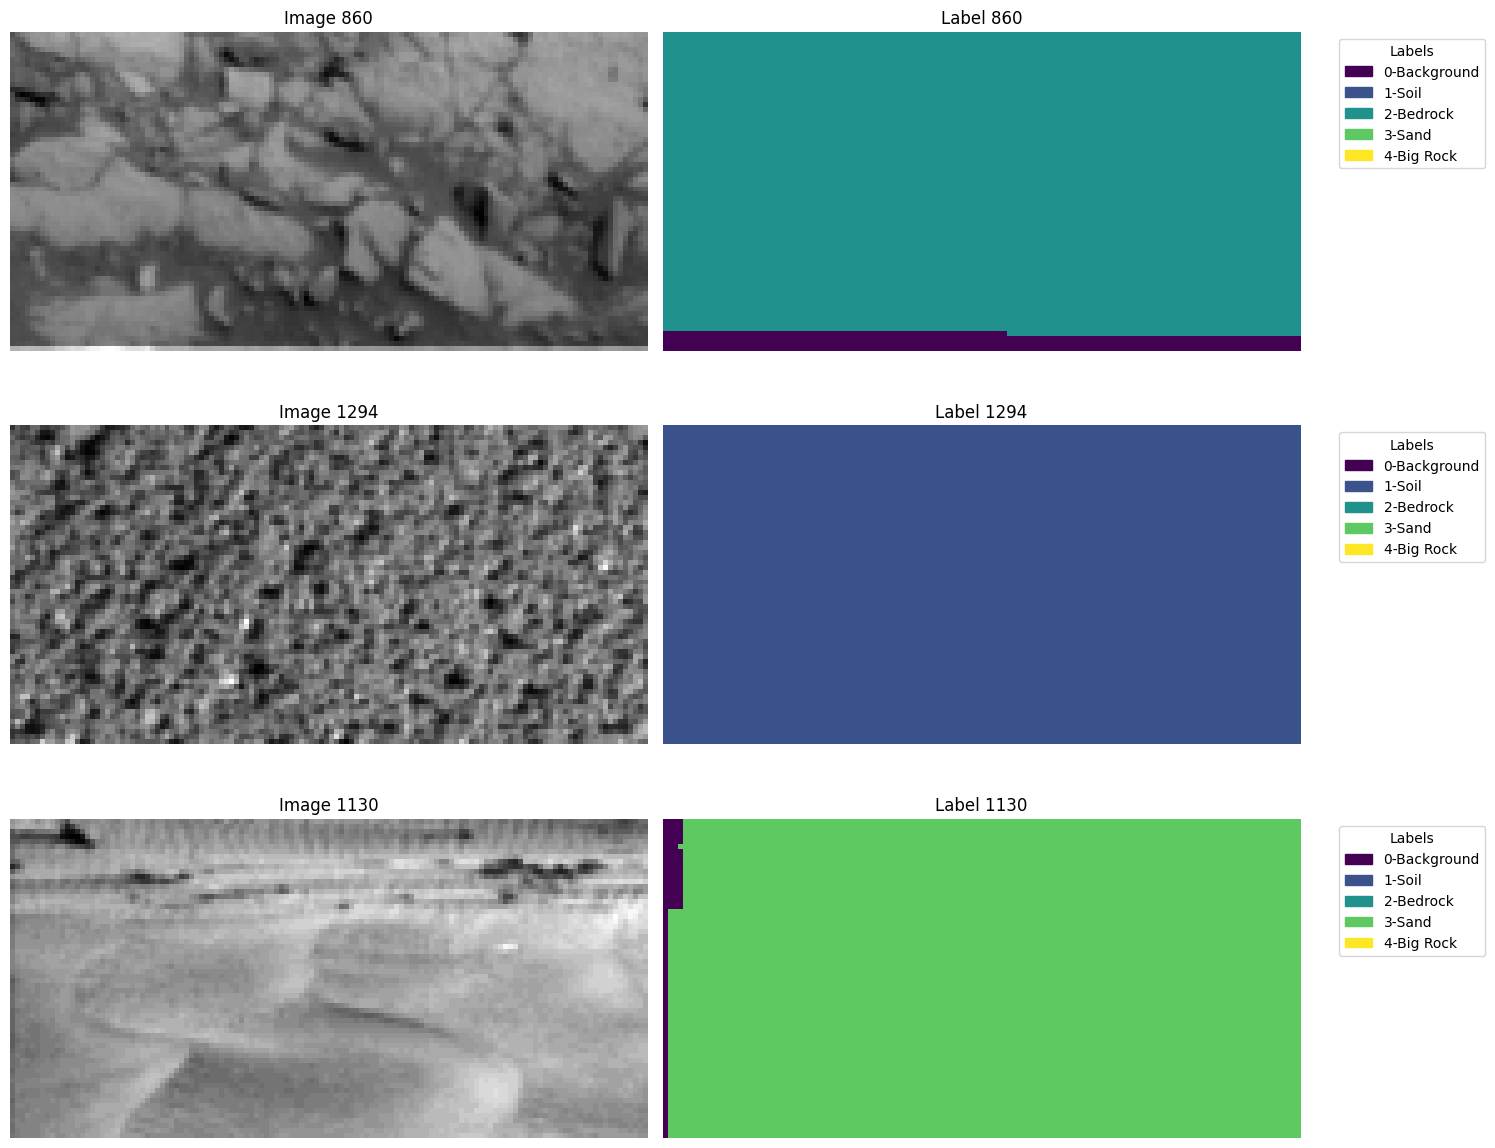

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))



def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]
    return colored



def add_colormap_legend(colormap, num_classes, labels_name):
    """
    Add a legend to the plot to show the mapping between labels and colors.

    Parameters:
    - colormap: The colormap used for segmentation.
    - num_classes: Number of classes.
    """
    patches = []
    for i in range(num_classes):
        color = colormap[i][:3]  # RGB values
        label = f"{i}-{labels_name[i]}"  # Customize label as needed
        patches.append(mpatches.Patch(color=color, label=label))

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")



def plot_sample_batch(X, y, labels_name, num_samples=3):
    """
    Display some image and label pairs from X and y with a legend.

    Parameters:
    - X: NumPy array of images, shape (N, H, W) or (N, H, W, C)
    - y: NumPy array of labels, shape (N, H, W)
    - num_samples: Number of samples to display
    """
    plt.figure(figsize=(15, 4 * num_samples))

    # Determine the number of classes from the labels
    num_classes = len(labels_name)
    colormap = create_segmentation_colormap(num_classes)

    # take random indices
    idx_rand = np.random.randint(0, X.shape[0], num_samples)

    for i, idx in enumerate(idx_rand):
        # Plot the original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(X[idx], cmap='gray')
        plt.title(f'Image {idx}')
        plt.axis('off')

        # Plot the colored label
        plt.subplot(num_samples, 2, i * 2 + 2)
        colored_label = apply_colormap(y[idx], colormap)
        plt.imshow(colored_label)
        plt.title(f'Label {idx}')
        plt.axis('off')
        add_colormap_legend(colormap, num_classes, labels_name)

    plt.tight_layout()
    plt.show()
    plt.close()



# visualize some samples
plot_sample_batch(X_train_val, y_train_val, labels_name, num_samples=3)

[4988826 6957538 4776810 3770823   26963]


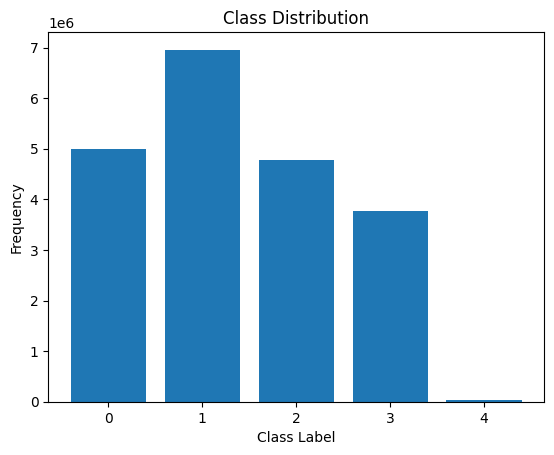

In [ ]:
mask_list = copy.deepcopy(y_train_val).astype(int)  # Each mask is a NumPy array

# Flatten all masks into a single array
all_pixels = np.concatenate([mask.flatten() for mask in mask_list])

# Count the frequency of each class
class_counts = np.bincount(all_pixels)
print(class_counts)

unique_classes = np.unique(all_pixels)
# Plot the class distribution
plt.bar(unique_classes, class_counts)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

### Splitting the data...

In [ ]:
# shuffle the data
X_train_val, y_train_val = shuffle(X_train_val, y_train_val, random_state=seed)

# Split train_val data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=seed)

print(f"Number of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Number of images:
Train: 2129
Validation: 376
Test: 10022


### Data Augmentation

In [ ]:
# function to visualize and better understand the augmentation transformations
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    _, ax = plt.subplots(2, 2, figsize=(8, 8))

    ax[0, 0].imshow(original_image, cmap='gray')
    ax[0, 0].set_title('Original image', fontsize=fontsize)
    ax[0, 0].axis('off')

    ax[1, 0].imshow(original_mask)
    ax[1, 0].set_title('Original mask', fontsize=fontsize)
    ax[1, 0].axis('off')

    ax[0, 1].imshow(image, cmap='gray')
    ax[0, 1].set_title('Transformed image', fontsize=fontsize)
    ax[0, 1].axis('off')

    ax[1, 1].imshow(mask)
    ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
    ax[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Define augmentations
augment = A.Compose([
    A.RandomCrop(width=128, height=64, p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
    ]),
    #A.GaussianBlur(blur_limit=(3, 3), p=0.5),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    A.Resize(width=128, height=64, always_apply=True)
])

In [ ]:
# Generator function for yielding batches of augmented data with multiple augmentations per image
def data_generator(images, masks, batch_size=32, num_augmentations=1):
    while True:  # Infinite loop to generate data for every epoch
        # Shuffle the data at the start of every epoch
        indices = np.random.permutation(len(images))  # Shuffle the indices
        # Initialize empty lists to store the batch data
        batch_images = []
        batch_masks = []

        for i in range(0, len(images), batch_size):
            # Get the indices for the current batch
            batch_indices = indices[i:i + batch_size]

            # Clear the lists for the batch data
            batch_images = []
            batch_masks = []

            # Collect images and masks for the current batch
            for idx in batch_indices:
                image = images[idx]
                mask = masks[idx]

                # Apply augmentations multiple times
                for _ in range(num_augmentations):
                    augmented = augment(image=image, mask=mask)

                    # Add the augmented data to the batch lists
                    batch_images.append(augmented['image'])
                    batch_masks.append(augmented['mask'])

            # Convert the batch to numpy arrays
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Yield the batch for training
            yield batch_images, batch_masks


# 🛠️ Models and Experiments

In [ ]:
def residual_block(input_tensor, filters, kernel_size=3, activation='relu', name='residual_block'):
    """
    residual block used in the bridge layer of the unet
    """
    skip = input_tensor

    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name + '_conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=name + '_bn1')(x)
    x = tfkl.Activation(activation, name=name + '_act1')(x)

    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name + '_conv2')(x)
    x = tfkl.BatchNormalization(name=name + '_bn2')(x)

    # Adjust skip connection dimension if needed
    if skip.shape[-1] != x.shape[-1]:
        skip = tfkl.Conv2D(filters, 1, padding='same')(skip)
        skip = tfkl.BatchNormalization()(skip)

    # Residual connection
    x = tfkl.Add(name=name + '_add')([x, skip])  # Add input to the output
    x = tfkl.Activation(activation, name=name + '_act2')(x)

    return x

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    return x

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, name=None, skip_method=tfkl.Concatenate(), seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, filters=64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, filters=128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, filters=256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)


    # Bottleneck
    bottleneck = residual_block(d3, filters=512, name='bottleneck')


    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)    # opposition to the max pooling. There are also other options
    u1 = tfkl.Dropout(0.2)(u1)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, filters=256, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, filters=128, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, filters=64, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    """
    why do we use a convolution instead of dense for the output layer?
    We could also use a dense layer and with kernel_size=1 there is no big difference,
    """

    return tfk.Model(inputs=input_layer, outputs=output_layer, name=name or 'UNet')

In [ ]:
class WeightedSumLayer(tfkl.Layer):
    def __init__(self, initial_alpha=0.6, **kwargs):
        super(WeightedSumLayer, self).__init__(**kwargs)
        self.alpha = tf.Variable(initial_alpha, trainable=True, name="learnable_alpha")

    def call(self, inputs):
        coarse_output_upsampled, fine_unet = inputs
        coarse_weighted = tf.math.multiply(self.alpha, coarse_output_upsampled)
        fine_weighted = tf.math.multiply(1 - self.alpha, fine_unet)
        return tfkl.Add(name="weighted_sum")([coarse_weighted, fine_weighted])

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 64)  │          256 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 64)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 64)  │       36,928 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 64)  │          256 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 64)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 128)  │       73,856 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 128)  │          512 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 128)  │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 128)  │      147,584 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 128)  │          512 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 7,926,917 (30.24 MB)

 Trainable params: 7,920,261 (30.21 MB)

 Non-trainable params: 6,656 (26.00 KB)

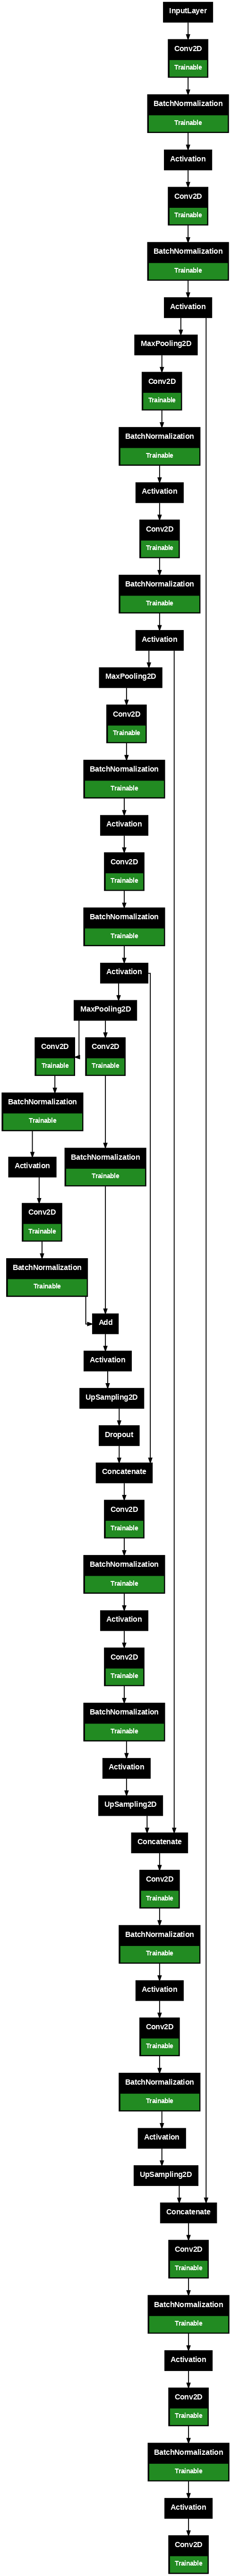

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tfk.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=70)
#model.save('model.h5')

In [ ]:
# used metric: Mean Intersection Over Union
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        """
        Custom MeanIoU metric that can exclude certain labels (e.g., background).
        """
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude or []

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Implements focal loss for multi-class classification with integer labels.

    Args:
        gamma: Gamma parameter to adjust the focus on hard examples.
        alpha: Weighting factor for each class.

    Returns:
        A function that computes the focal loss.
    """
    @tf.keras.utils.register_keras_serializable()
    def focal_loss_impl(y_true, y_pred):
        # Calculate cross-entropy loss
        # Convert y_true to one-hot encoding
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)

        # Reshape to match y_pred
        y_true_onehot = tf.reshape(y_true_onehot, tf.shape(y_pred))

        cross_entropy = tf.keras.losses.CategoricalCrossentropy()(y_true_onehot, y_pred)

        # Calculate focal loss factor
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        # Calculate p_t using one-hot encoded y_true
        p_t = tf.reduce_sum(y_true_onehot * y_pred, axis=-1)

        alpha_factor = tf.reduce_sum(y_true_onehot * alpha, axis=-1) + tf.reduce_sum((1 - y_true_onehot) * (1 - alpha), axis=-1)
        focal_factor = tf.pow((1 - p_t), gamma)
        loss = alpha_factor * focal_factor * cross_entropy
        return loss
    return focal_loss_impl

In [ ]:
def calculate_class_weights(y):

  mask_list = copy.deepcopy(y).astype(int)  # Each mask is a NumPy array

  # Flatten all masks into a single array
  all_pixels = np.concatenate([mask.flatten() for mask in mask_list])

  # Count the frequency of each class
  class_counts = np.bincount(all_pixels)

  total_samples = len(y.flatten())
  class_weights = [total_samples / count for count in class_counts]
  class_weights = class_weights / np.sum(class_weights)
  return class_weights

class_weights = calculate_class_weights(y_train)
print(class_weights)

[0.00474614 0.00345622 0.00500529 0.00648783 0.98030453]


In [ ]:
# Compile the model
model.compile(
    loss=focal_loss(gamma=2.0, alpha=class_weights),
    optimizer=tf.keras.optimizers.Lion(1e-4),
    metrics=[tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, name="mean_iou")]
)

# 🛠️ Train and Save the Model

In [ ]:
# callback for visualization during training
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, X, y, frequency=5):
        """
        Visualization callback to monitor predictions during training.

        Parameters:
        - X: NumPy array of input images.
        - y: NumPy array of ground truth masks.
        - frequency: How often (in epochs) to visualize predictions.
        """
        super().__init__()
        self.X = X
        self.y = y
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize every "frequency" epochs
            idx = 207  # Select the index of the image to plot
            image = self.X[idx]
            label = self.y[idx]

            # Add batch dimension to the image
            image_input = np.expand_dims(image, axis=0)
            pred = self.model.predict(image_input, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]  # Remove batch dimension

            # Create colormap
            num_classes = len(np.unique(self.y))  # Determine number of classes from the labels
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            add_colormap_legend(colormap, NUM_CLASSES, labels_name)

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Setup callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mean_iou', patience=20, mode='max', restore_best_weights=True)
lr_scheduling = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', factor=0.5, patience=15, min_lr=1e-6, min_delta=4e-6)
viz_callback = VizCallback(X_val, y_val, frequency=10)

Epoch 1/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 1.7563 - mean_iou: 0.2311

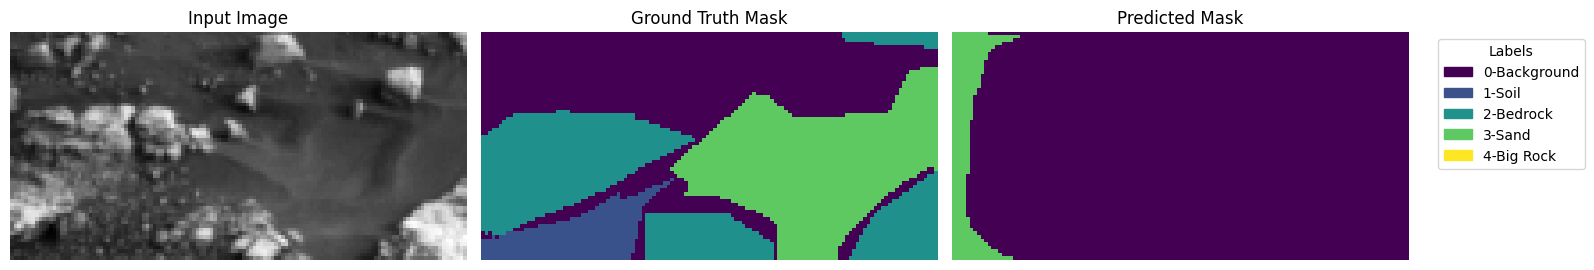

266/266 ━━━━━━━━━━━━━━━━━━━━ 120s 297ms/step - loss: 1.7551 - mean_iou: 0.2312 - val_loss: 108.3635 - val_mean_iou: 0.0082 - learning_rate: 1.0000e-04
Epoch 2/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 1.0179 - mean_iou: 0.3248 - val_loss: 3.4006 - val_mean_iou: 0.1463 - learning_rate: 1.0000e-04
Epoch 3/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.8635 - mean_iou: 0.3533 - val_loss: 5.8144 - val_mean_iou: 0.0975 - learning_rate: 1.0000e-04
Epoch 4/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.7523 - mean_iou: 0.3709 - val_loss: 1.2023 - val_mean_iou: 0.2457 - learning_rate: 1.0000e-04
Epoch 5/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.7323 - mean_iou: 0.3842 - val_loss: 0.5954 - val_mean_iou: 0.4096 - learning_rate: 1.0000e-04
Epoch 6/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - loss: 0.6645 - mean_iou: 0.4048 - val_loss: 0.7248 - val_mean_iou: 0.3564 - learning_rate: 1.0000e-04
Epoch 7/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183m

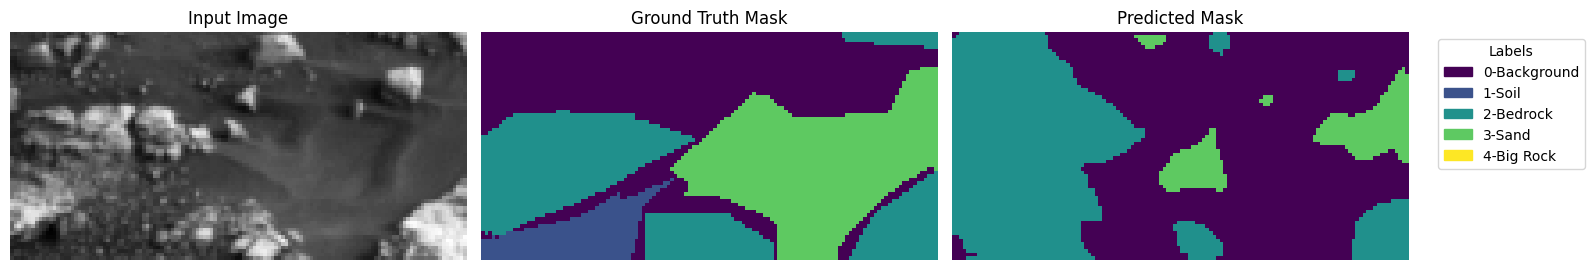

266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.5450 - mean_iou: 0.4307 - val_loss: 0.5817 - val_mean_iou: 0.4073 - learning_rate: 1.0000e-04
Epoch 12/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.5360 - mean_iou: 0.4297 - val_loss: 0.4229 - val_mean_iou: 0.4528 - learning_rate: 1.0000e-04
Epoch 13/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 182ms/step - loss: 0.5449 - mean_iou: 0.4248 - val_loss: 2.4307 - val_mean_iou: 0.1783 - learning_rate: 1.0000e-04
Epoch 14/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.5328 - mean_iou: 0.4313 - val_loss: 1.9154 - val_mean_iou: 0.1773 - learning_rate: 1.0000e-04
Epoch 15/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.4990 - mean_iou: 0.4343 - val_loss: 0.4783 - val_mean_iou: 0.4179 - learning_rate: 1.0000e-04
Epoch 16/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.5311 - mean_iou: 0.4319 - val_loss: 0.5454 - val_mean_iou: 0.3995 - learning_rate: 1.0000e-04
Epoch 17/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 1

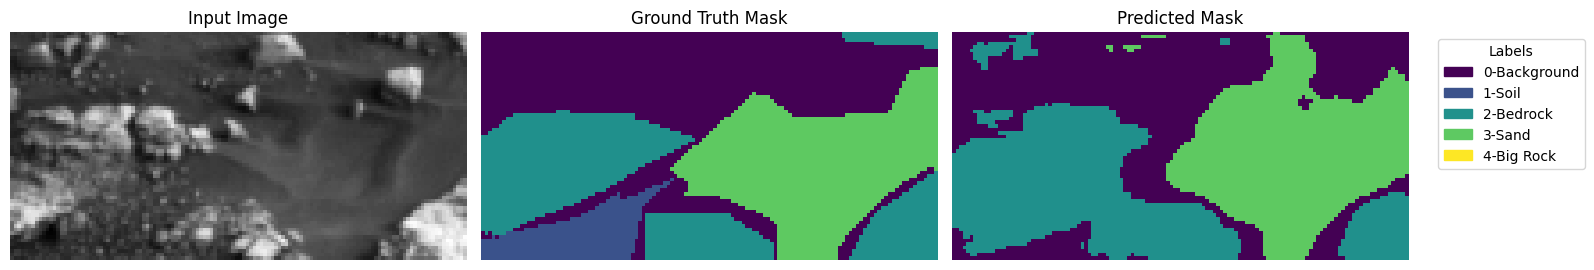

266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.4363 - mean_iou: 0.4504 - val_loss: 0.3361 - val_mean_iou: 0.4833 - learning_rate: 5.0000e-05
Epoch 22/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 182ms/step - loss: 0.4225 - mean_iou: 0.4576 - val_loss: 0.4423 - val_mean_iou: 0.4344 - learning_rate: 5.0000e-05
Epoch 23/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - loss: 0.4125 - mean_iou: 0.4554 - val_loss: 0.6438 - val_mean_iou: 0.3861 - learning_rate: 5.0000e-05
Epoch 24/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.4370 - mean_iou: 0.4539 - val_loss: 0.3363 - val_mean_iou: 0.4740 - learning_rate: 5.0000e-05
Epoch 25/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.4205 - mean_iou: 0.4544 - val_loss: 0.4154 - val_mean_iou: 0.4402 - learning_rate: 5.0000e-05
Epoch 26/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - loss: 0.4050 - mean_iou: 0.4548 - val_loss: 0.3509 - val_mean_iou: 0.4799 - learning_rate: 5.0000e-05
Epoch 27/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 1

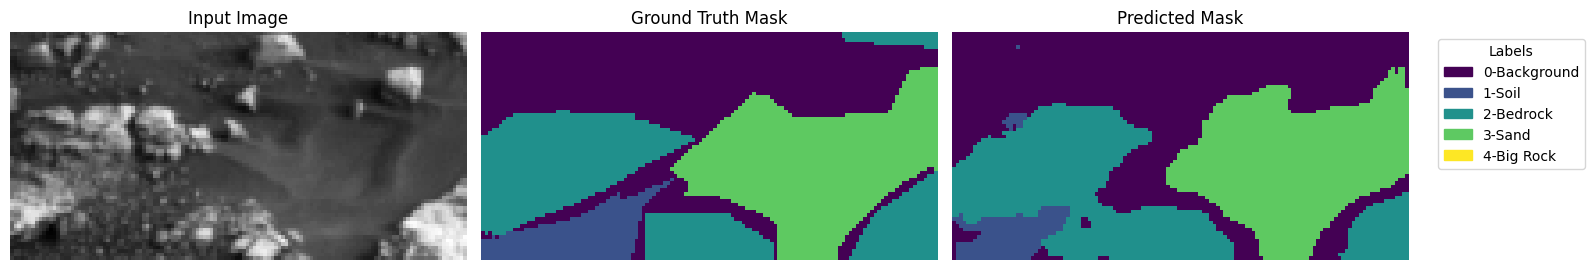

266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.4117 - mean_iou: 0.4573 - val_loss: 0.3763 - val_mean_iou: 0.4599 - learning_rate: 5.0000e-05
Epoch 32/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.4302 - mean_iou: 0.4565 - val_loss: 0.3325 - val_mean_iou: 0.4810 - learning_rate: 2.5000e-05
Epoch 33/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3800 - mean_iou: 0.4648 - val_loss: 0.3091 - val_mean_iou: 0.4903 - learning_rate: 2.5000e-05
Epoch 34/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.3838 - mean_iou: 0.4684 - val_loss: 0.3198 - val_mean_iou: 0.4902 - learning_rate: 2.5000e-05
Epoch 35/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3743 - mean_iou: 0.4667 - val_loss: 0.3019 - val_mean_iou: 0.4804 - learning_rate: 2.5000e-05
Epoch 36/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3910 - mean_iou: 0.4635 - val_loss: 0.3116 - val_mean_iou: 0.4817 - learning_rate: 2.5000e-05
Epoch 37/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 1

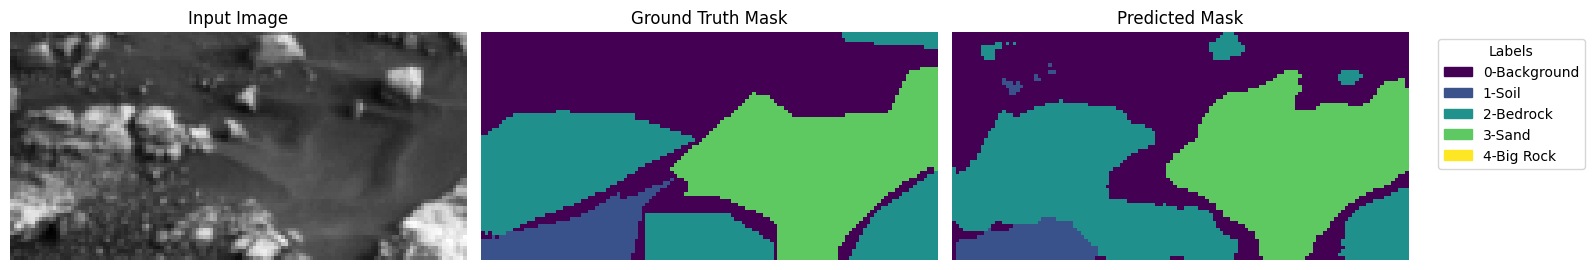

266/266 ━━━━━━━━━━━━━━━━━━━━ 50s 186ms/step - loss: 0.3629 - mean_iou: 0.4747 - val_loss: 0.3249 - val_mean_iou: 0.4888 - learning_rate: 2.5000e-05
Epoch 42/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3745 - mean_iou: 0.4686 - val_loss: 0.2875 - val_mean_iou: 0.4961 - learning_rate: 2.5000e-05
Epoch 43/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.3261 - mean_iou: 0.4806 - val_loss: 0.2933 - val_mean_iou: 0.4898 - learning_rate: 2.5000e-05
Epoch 44/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3651 - mean_iou: 0.4675 - val_loss: 0.3101 - val_mean_iou: 0.4843 - learning_rate: 2.5000e-05
Epoch 45/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3554 - mean_iou: 0.4694 - val_loss: 0.2902 - val_mean_iou: 0.4939 - learning_rate: 2.5000e-05
Epoch 46/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3385 - mean_iou: 0.4751 - val_loss: 0.3058 - val_mean_iou: 0.4815 - learning_rate: 2.5000e-05
Epoch 47/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 1

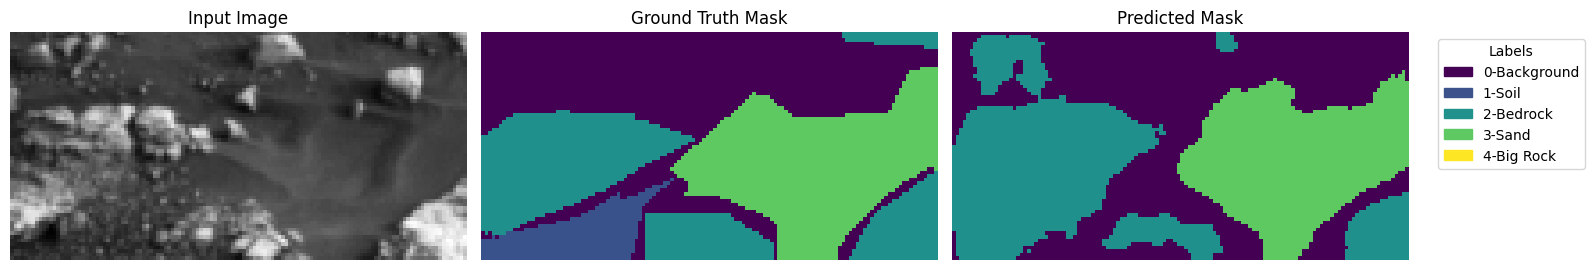

266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.3331 - mean_iou: 0.4755 - val_loss: 0.2728 - val_mean_iou: 0.4905 - learning_rate: 1.2500e-05
Epoch 52/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.3428 - mean_iou: 0.4738 - val_loss: 0.2713 - val_mean_iou: 0.4973 - learning_rate: 1.2500e-05
Epoch 53/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3202 - mean_iou: 0.4818 - val_loss: 0.2619 - val_mean_iou: 0.4969 - learning_rate: 1.2500e-05
Epoch 54/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3319 - mean_iou: 0.4795 - val_loss: 0.2753 - val_mean_iou: 0.4918 - learning_rate: 1.2500e-05
Epoch 55/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3236 - mean_iou: 0.4807 - val_loss: 0.2703 - val_mean_iou: 0.4958 - learning_rate: 1.2500e-05
Epoch 56/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - loss: 0.3164 - mean_iou: 0.4824 - val_loss: 0.2884 - val_mean_iou: 0.4828 - learning_rate: 1.2500e-05
Epoch 57/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 1

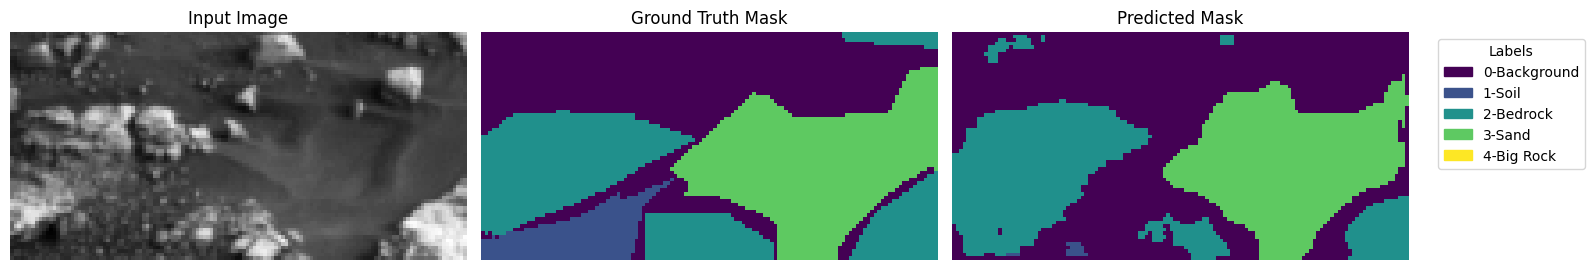

266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.3154 - mean_iou: 0.4834 - val_loss: 0.2611 - val_mean_iou: 0.4934 - learning_rate: 1.2500e-05
Epoch 62/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.3025 - mean_iou: 0.4868 - val_loss: 0.2644 - val_mean_iou: 0.4954 - learning_rate: 6.2500e-06
Epoch 63/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3065 - mean_iou: 0.4814 - val_loss: 0.2490 - val_mean_iou: 0.5039 - learning_rate: 6.2500e-06
Epoch 64/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - loss: 0.3016 - mean_iou: 0.4826 - val_loss: 0.2591 - val_mean_iou: 0.4955 - learning_rate: 6.2500e-06
Epoch 65/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.3024 - mean_iou: 0.4874 - val_loss: 0.2526 - val_mean_iou: 0.5015 - learning_rate: 6.2500e-06
Epoch 66/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.2960 - mean_iou: 0.4865 - val_loss: 0.2528 - val_mean_iou: 0.5037 - learning_rate: 6.2500e-06
Epoch 67/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 1

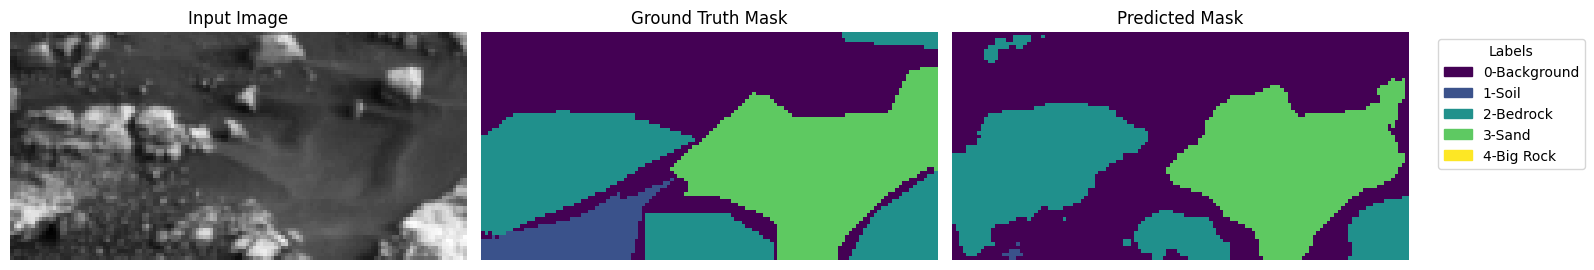

266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - loss: 0.3107 - mean_iou: 0.4826 - val_loss: 0.2540 - val_mean_iou: 0.4975 - learning_rate: 6.2500e-06
Epoch 72/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.3234 - mean_iou: 0.4841 - val_loss: 0.2477 - val_mean_iou: 0.5009 - learning_rate: 6.2500e-06
Epoch 73/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - loss: 0.3069 - mean_iou: 0.4832 - val_loss: 0.2504 - val_mean_iou: 0.5007 - learning_rate: 6.2500e-06
Epoch 74/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.3045 - mean_iou: 0.4834 - val_loss: 0.2501 - val_mean_iou: 0.5028 - learning_rate: 6.2500e-06
Epoch 75/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3259 - mean_iou: 0.4751 - val_loss: 0.2496 - val_mean_iou: 0.5045 - learning_rate: 6.2500e-06
Epoch 76/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3070 - mean_iou: 0.4876 - val_loss: 0.2481 - val_mean_iou: 0.5039 - learning_rate: 6.2500e-06
Epoch 77/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 1

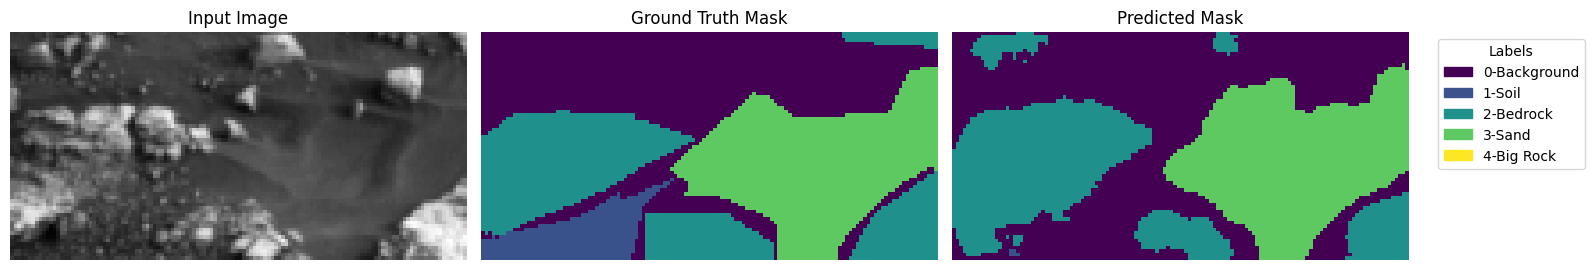

266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - loss: 0.3036 - mean_iou: 0.4858 - val_loss: 0.2472 - val_mean_iou: 0.5044 - learning_rate: 3.1250e-06
Epoch 82/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.2949 - mean_iou: 0.4938 - val_loss: 0.2484 - val_mean_iou: 0.5022 - learning_rate: 3.1250e-06
Epoch 83/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.2831 - mean_iou: 0.4920 - val_loss: 0.2500 - val_mean_iou: 0.5009 - learning_rate: 3.1250e-06
Epoch 84/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.3178 - mean_iou: 0.4849 - val_loss: 0.2470 - val_mean_iou: 0.5018 - learning_rate: 3.1250e-06
Epoch 85/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.2924 - mean_iou: 0.4928 - val_loss: 0.2507 - val_mean_iou: 0.5015 - learning_rate: 3.1250e-06
Epoch 86/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - loss: 0.2908 - mean_iou: 0.4929 - val_loss: 0.2516 - val_mean_iou: 0.4991 - learning_rate: 3.1250e-06
Epoch 87/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 1

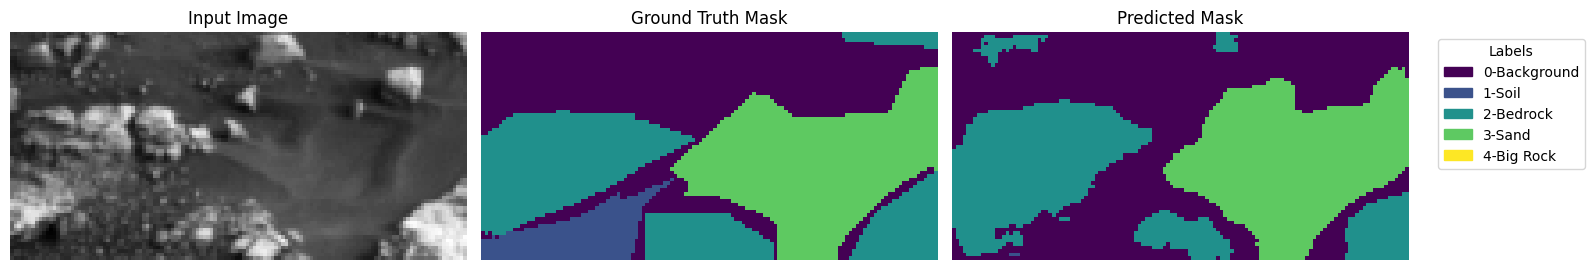

266/266 ━━━━━━━━━━━━━━━━━━━━ 50s 187ms/step - loss: 0.3121 - mean_iou: 0.4876 - val_loss: 0.2512 - val_mean_iou: 0.4991 - learning_rate: 3.1250e-06
Epoch 92/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - loss: 0.2719 - mean_iou: 0.4946 - val_loss: 0.2513 - val_mean_iou: 0.4979 - learning_rate: 1.5625e-06
Epoch 93/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.2764 - mean_iou: 0.4922 - val_loss: 0.2515 - val_mean_iou: 0.4989 - learning_rate: 1.5625e-06
Epoch 94/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - loss: 0.2865 - mean_iou: 0.4916 - val_loss: 0.2481 - val_mean_iou: 0.5016 - learning_rate: 1.5625e-06
Epoch 95/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.3058 - mean_iou: 0.4856 - val_loss: 0.2499 - val_mean_iou: 0.4993 - learning_rate: 1.5625e-06
Final validation Mean Intersection Over Union: 50.45113563537598 %


In [ ]:
# Train the model
batch_size = 16
num_augmentations = 2

history = model.fit(
    data_generator(X_train, y_train, batch_size=batch_size, num_augmentations=num_augmentations),
    steps_per_epoch=(len(X_train) * num_augmentations) // batch_size,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping,lr_scheduling, viz_callback],
    verbose=1,
).history

# Calculate and print the final validation Mean Intersection Over Union
final_val_mean_iou = max(history['val_mean_iou'])* 100
print(f'Final validation Mean Intersection Over Union: {final_val_mean_iou} %')

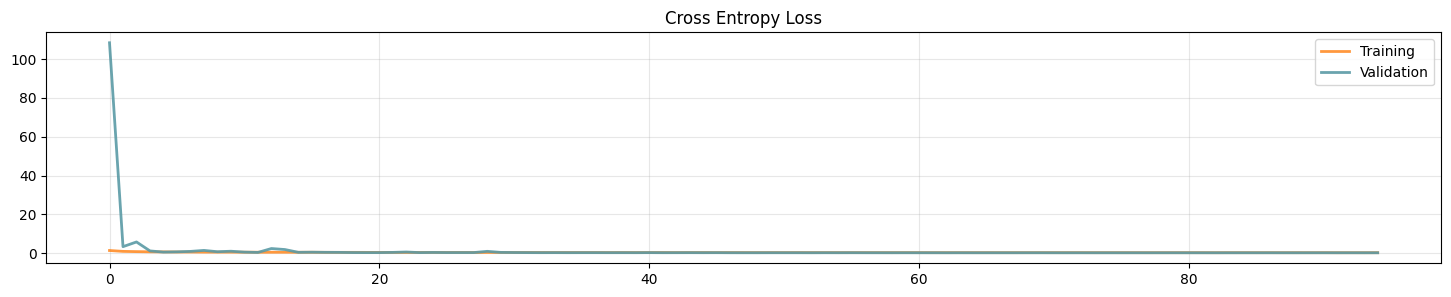

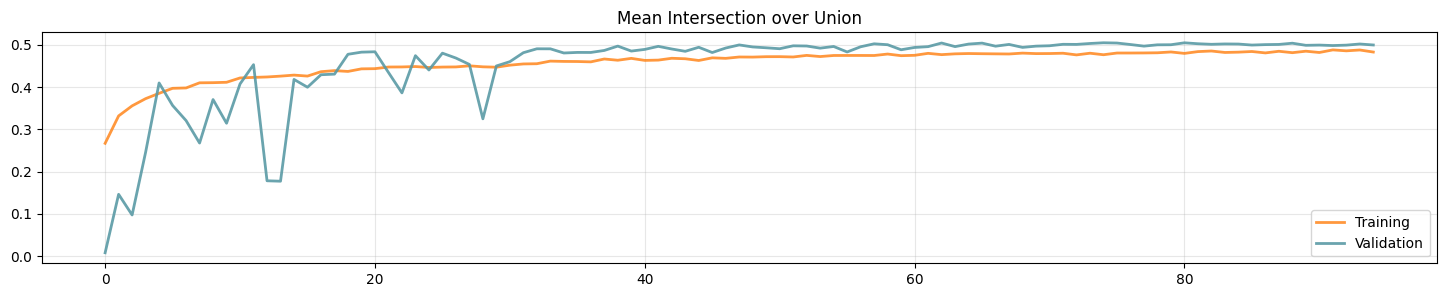

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# save the model and remove it from memory

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241207_120100.keras


# 📊 Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241207_120100.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>